#### Load all needed python libraries

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

#### Load, clean, prepare the dataset

In [ ]:
df = pd.read_csv('./data/globalterrorismdb_0718dist.csv', encoding='cp1252')
row, col = df.shape
print(f"Columns: {col}")
print(f"Row: {row}")

# Select relevant columns
columns = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt',
           'nkill', 'nwound', 'success', 'suicide']

df = df[columns]

df.head()

# check for missing values
missing = df.isnull().sum().sort_values(ascending=False)
print(missing)

# fill missing values based on the missing columns
df['nkill'] = df['nkill'].fillna(0)
df['nwound'] = df['nwound'].fillna(0)
df['imonth'] = df['imonth'].replace(0, 1).fillna(1).astype(int)
df['iday'] = df['iday'].replace(0, 1).fillna(1).astype(int)

# drop rows with missing critical categorical data
df.dropna(subset=['attacktype1_txt', 'targtype1_txt',
          'weaptype1_txt'], inplace=True)
df.dropna(subset=['iyear'], inplace=True)


df['iyear'] = df['iyear'].astype(int)
# Feature Engineering, create new columns
df['casualties'] = df['nkill'] + df['nwound']
df['attack_date'] = pd.to_datetime(
    dict(year=df['iyear'], month=df['imonth'], day=df['iday']),
    errors='coerce'
)

categorical_cols = ['country_txt', 'region_txt', 'provstate', 'city',
                    'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt']

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print(df.describe())

/var/folders/09/8p6g2q6j041bm2lhj8gf0nkh0000gn/T/ipykernel_33467/3706970863.py:1: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/globalterrorismdb_0718dist.csv', encoding='cp1252')


Columns: 135
Row: 181691
nwound             16311
nkill              10313
city                 435
provstate            421
iyear                  0
imonth                 0
iday                   0
country_txt            0
region_txt             0
attacktype1_txt        0
targtype1_txt          0
weaptype1_txt          0
success                0
suicide                0
dtype: int64


#### Basic Data Analysis

1. Create a Relational Graph (Scatter Plot) to show year vs casualties
2. Create a Categorical Graph (Bar Plot) to show the types of attacks over the years
3. Create a Statiscal Graph ( Heatmap ) to show the correlation relationship the features

In [5]:
def plot_year_vs_casualties(df):
    yearly_casualties = df.groupby('iyear')['casualties'].sum().reset_index()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=yearly_casualties, x='iyear', y='casualties', color='crimson')
    plt.title('Total Casualties per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Casualties')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_year_vs_casualties(df)

In [7]:
def plot_attack_types(df, label_encoders):
    dpat = df.copy()
    attack_labels = label_encoders['attacktype1_txt'].inverse_transform(
        dpat['attacktype1_txt'])
    dpat['attack_label'] = attack_labels

    attack_counts = dpat['attack_label'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=attack_counts.values,
                y=attack_counts.index, palette='viridis')
    plt.title('Top 10 Attacks over the years')
    plt.xlabel('Number of Attacks')
    plt.ylabel('Attack Type')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_attack_types(df, label_encoders)

In [ ]:
def plot_attack_type_correlation_heatmap(df, col):
    df_copy = df.copy()
    df_copy['attack_label'] = label_encoders['attacktype1_txt'].inverse_transform(df_copy['attacktype1_txt'])

    pivot = df_copy.pivot_table(
        index='attack_label',
        columns=col,
        values='casualties',
        aggfunc='count',
        fill_value=0
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Attack Type vs {col} Heatmap')
    plt.xlabel(f'{col} (0 = No, 1 = Yes)')
    plt.ylabel('Attack Type')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_attack_type_correlation_heatmap(df, 'success')
plot_attack_type_correlation_heatmap(df, 'suicide')

#### Create Clustering Methodology

Use-case:
1. Behaviour Based Clustering

Solve using the following:
1. K-means + Elbow Plot + Silhoutte Plot

In [76]:
def elbow_plot(df):
    features = ['casualties', 'success', 'suicide', 'attacktype1_txt']
    X = df[features]
    X_scaled = StandardScaler().fit_transform(X)

    distortions = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8,6))
    plt.plot(range(1, 11), distortions, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.tight_layout()
    plt.show()


In [77]:
def silhouette_plot(df, max_k = 10):
    features = ['casualties', 'success', 'suicide', 'attacktype1_txt']
    sample_idx = np.random.choice(df.index, size=10000, replace=False)
    df_sample = df.loc[sample_idx]
    X = df_sample[features]
    X_scaled = StandardScaler().fit_transform(X)

    K_range = range(2, max_k + 1)
    scores = np.zeros(len(K_range))

    for i, k in enumerate(K_range):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        scores[i] = silhouette_score(X_scaled, labels)

    optimal_k = K_range[np.argmax(scores)]

    plt.figure(figsize=(8, 6))
    plt.plot(K_range, scores, marker='o')
    plt.axvline(optimal_k, color='red', linestyle='--')
    plt.text(optimal_k + 0.2, scores.max() - 0.02,
             f'Optimal K = {optimal_k}', color='red')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

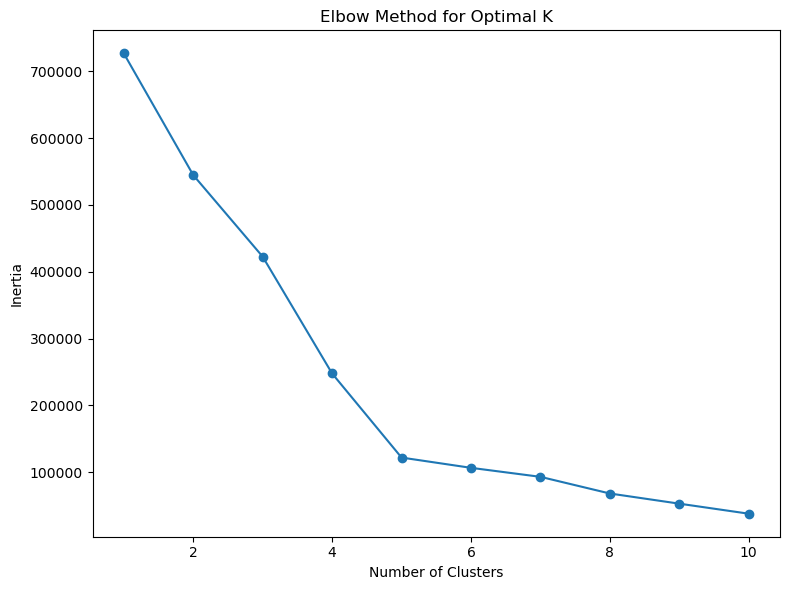

In [78]:
elbow_plot(df)

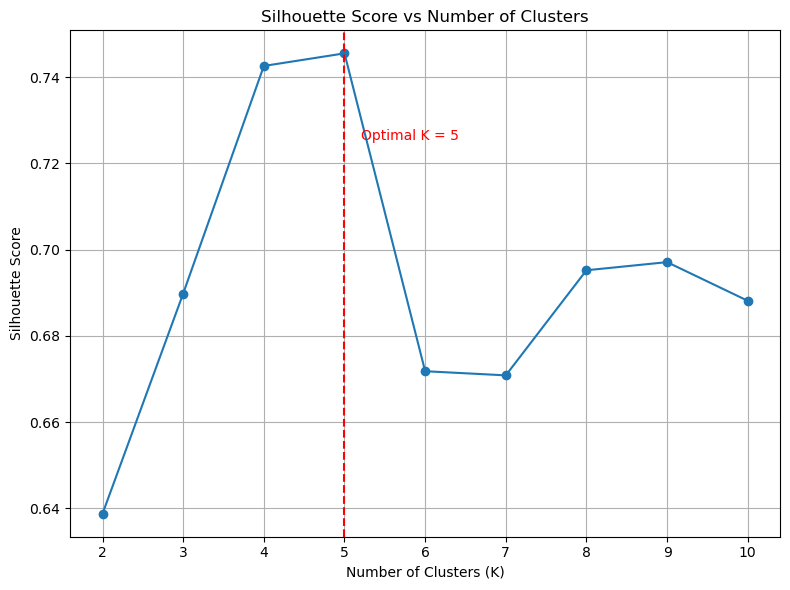

In [79]:
silhouette_plot(df)

#### Visualize the Clustering

1. Create a plot for the clustering based on the Optimal K = 5

In [ ]:
def kmeans_clustering(df, label_encoders, n_clusters = 5):
    features = ['casualties', 'success', 'suicide', 'attacktype1_txt']
    X = df[features]
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    df['attack_label'] = label_encoders['attacktype1_txt'].inverse_transform(
        df['attacktype1_txt'])
    dominant_labels = df.groupby('cluster')['attack_label'].agg(
        lambda x: x.value_counts().idxmax())
    X_pca = PCA(n_components=2).fit_transform(X_scaled)
    df['pca1'] = X_pca[:, 0]
    df['pca2'] = X_pca[:, 1]

    plt.figure(figsize=(10,6))
    sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='tab10', alpha=0.6)

    for cluster_id in range(5):
        cluster_data = df[df['cluster'] == cluster_id]
        x_mean = cluster_data['pca1'].mean()
        y_mean = cluster_data['pca2'].mean()
        label = f"Cluster {cluster_id}: {dominant_labels[cluster_id]}"
        plt.text(x_mean + 1.5, y_mean + 0.5, label, fontsize=12, weight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.7))

    plt.title('KMeans Clustering with Dominant Attack Type Labels')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

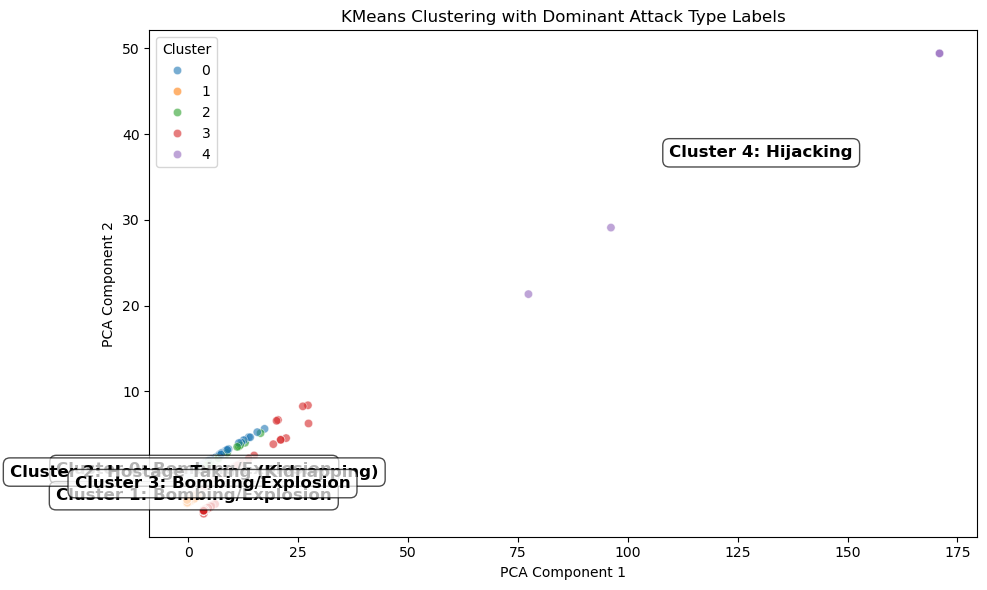

In [95]:
kmeans_clustering(df, label_encoders)

#### Create a Fitting using Linear Regression

We will predict the casualties based on the following features:

1. Success
2. Suicide
3. Attack Type
4. Region
5. Weapon Type

In [ ]:
def fitting_linear_regression(df, features, isLog = False,):
    target = 'casualties'
    features = features
    X = df[features]
    y = df[target]

    if isLog:
        y = np.log1p(df[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    LR_model = LinearRegression()
    LR_model.fit(X_train, y_train)

    y_pred = LR_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse: .2f}")
    print(f"R2 Score: {r2: .2f}")

    coef = pd.DataFrame({
        "Feature": features,
        'Coefficient': LR_model.coef_
    })

    print(coef)

In [133]:
def tree_based_models(df, features, isLog = False):
    features = features
    X = df[features]
    y = df['casualties']

    if isLog:
        y = np.log1p(y)

    X_scaled = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    RandomForestModel = RandomForestRegressor(n_estimators=100, random_state=42)
    RandomForestModel.fit(X_train, y_train)

    y_pred_rfm = RandomForestModel.predict(X_test)
    mse_rfm = mean_squared_error(y_test, y_pred_rfm)
    r2_rfm = r2_score(y_test, y_pred_rfm)

    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred_gb = gb_model.predict(X_test)
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    print(f"Mean Squared Error - Random Forest: {mse_rfm:.2f}")
    print(f"R² Score - Random Forest: {r2_rfm:.2f}")

    print(f"Mean Squared Error - GradientBoostingRegressor: {mse_gb:.2f}")
    print(f"R² Score - GradientBoostingRegressor: {r2_gb:.2f}")


    # Random Forest Residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_rfm, y_test - y_pred_rfm, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residual Plot for Random Forest')
    plt.xlabel('Predicted Casualties')
    plt.ylabel('Residuals')

    # Gradient Boosting Residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_gb, y_test - y_pred_gb, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residual Plot for Gradient Boosting')
    plt.xlabel('Predicted Casualties')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

In [106]:
features = ['success', 'suicide', 'attacktype1_txt',
            'region_txt', 'weaptype1_txt']
fitting_linear_regression(df, features)

Mean Squared Error:  2819.22
R2 Score:  0.01
           Feature  Coefficient
0          success     4.754921
1          suicide    24.828967
2  attacktype1_txt     0.092345
3       region_txt    -0.114466
4    weaptype1_txt    -0.094566


In [107]:
features = ['success', 'suicide', 'attacktype1_txt',
            'region_txt', 'weaptype1_txt']
fitting_linear_regression(df, features, True)

Mean Squared Error:  1.00
R2 Score:  0.13
           Feature  Coefficient
0          success     0.674950
1          suicide     1.611066
2  attacktype1_txt    -0.063188
3       region_txt    -0.016858
4    weaptype1_txt     0.011225


In [117]:
features = ['success', 'suicide', 'attacktype1_txt', 'region_txt', 'weaptype1_txt',
            'targtype1_txt', 'country_txt', 'iyear', 'imonth']
fitting_linear_regression(df, features, True)

Mean Squared Error:  0.97
R2 Score:  0.16
           Feature  Coefficient
0          success     0.717557
1          suicide     1.495502
2  attacktype1_txt    -0.073943
3       region_txt    -0.016105
4    weaptype1_txt     0.019982
5    targtype1_txt     0.008326
6      country_txt    -0.000888
7            iyear     0.012038
8           imonth     0.004694


In [129]:
features = ['success', 'suicide', 'attacktype1_txt',
            'region_txt', 'weaptype1_txt']
tree_based_models(df, features)

Mean Squared Error - Random Forest: 1771.78
R² Score - Random Forest: 0.38
Mean Squared Error - GradientBoostingRegressor: 1745.79
R² Score - GradientBoostingRegressor: 0.39


Mean Squared Error - Random Forest: 1154.79
R² Score - Random Forest: 0.60
Mean Squared Error - GradientBoostingRegressor: 1205.52
R² Score - GradientBoostingRegressor: 0.58


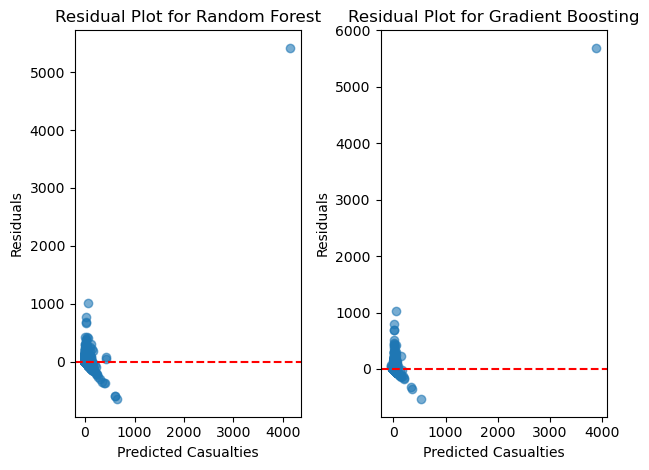

In [134]:
features = ['success', 'suicide', 'attacktype1_txt', 'region_txt', 'weaptype1_txt',
            'targtype1_txt', 'country_txt', 'iyear', 'imonth']
tree_based_models(df, features)